# Refs

- https://github.com/ayushishakya/Space-Dynamics
- https://github.com/yitlinn/OrbitalMechanics/tree/dae69b632cce5c9f7599be8d867653195152a59f
- https://github.com/SeungminHwang/KAIST-PH222-Project1/

In [1]:
import numpy as np

def deltaV_Hohmann_circular(r_a, r_b, mu):
    #rb greater than ra
    a = r_b/r_a
    A = 1/np.sqrt(a)
    B = -1*(np.sqrt(2)*(1-a))/np.sqrt(a*(1+a))
    C = np.sqrt(mu/r_a)
    return (A + B - 1)*C

def deltaV_Bielliptic_circular(r_a, r_b, r_c, mu):
    #rb is transfer ellipse
    a = r_c/r_a
    b = r_b/r_a
    A = np.sqrt((2*(a + b))/(a*b))
    B = -1*((1 + np.sqrt(a))/np.sqrt(a))
    C = -1*np.sqrt(2/(b*(1+b)))*(1-b)
    D = np.sqrt(mu/r_a)
    return (A + B + C)*D

def t_circular(r, mu):
    return ((2*np.pi)/np.sqrt(mu))*r**1.5

def t_ellipse(r_p, r_a, mu):
    a = (r_a + r_p)/2
    return ((2*np.pi)/np.sqrt(mu))*a**1.5

#Find the total delta-v requirement for a bi-elliptical Hohmann
#transfer from a geocentric circular orbit of 7000 km radius to
#one of 105 000 km radius. Let the apogee of the first ellipse
#be 210 000 km. Compare the delta-v schedule and total flight time
#with that for an ordinary single Hohmann transfer ellipse.

r_o1 = 7000
r_o2 = 210000
r_o3 = 105000
mu = 398600

#Compare delta v

dv_hohmann = deltaV_Hohmann_circular(r_o1, r_o3, mu)
dv_biell = deltaV_Bielliptic_circular(r_o1, r_o2, r_o3, mu)

if dv_biell < dv_hohmann:
    print('Bi-elliptic transfer more efficient by ' + 
          str(round(dv_hohmann - dv_biell, 4)) + ' km/s')


#Compare flight times
#Hohmann:
dt_hohmann = t_ellipse(r_o1, r_o3, mu)/2

#Bi-elliptic:
dt_biell_1 = t_ellipse(r_o1, r_o2, mu)/2
dt_biell_2 = t_ellipse(r_o2, r_o3, mu)/2
dt_biell = dt_biell_1 + dt_biell_2

print('Bi-elliptic transfer takes ' +
      str(round((dt_biell - dt_hohmann)/3600, 4)) + ' hours longer')

Bi-elliptic transfer more efficient by 0.0178 km/s
Bi-elliptic transfer takes 117.4795 hours longer


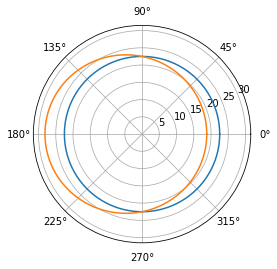

In [2]:
import matplotlib.pyplot as pl

#Orbit Equation Plotter

def orbit_equation_r(h, mu, e, theta):
    A = h**2/mu
    B = 1 + e*np.cos(theta)
    return A/B

theta_array = np.linspace(0, 2*np.pi, 200)
r_array = [orbit_equation_r(30, 40, 0, theta) for theta in theta_array]
r_array_1 = [orbit_equation_r(30, 40, 0.2, theta) for theta in theta_array]

fig, ax = pl.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_array, r_array)
ax.plot(theta_array, r_array_1)
ax.set_rmax(1.4*max((r_array)))
pl.show()


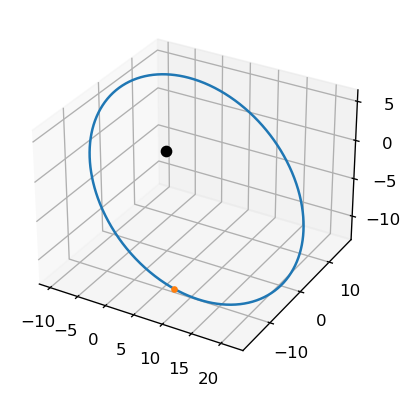

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Required functions:

def stumpff_S(z):
    if z > 0:
        x = np.sqrt(z)
        return (x - np.sin(x))/(x)**3
    elif z < 0:
        y = np.sqrt(-z)
        return (np.sinh(y) - y)/(y)**3
    else:
        return (1/6)
        
def stumpff_C(z):
    if z > 0:
        return (1 - np.cos(np.sqrt(z)))/z
    elif z < 0:
        return (np.cosh(np.sqrt(-z)) - 1)/(-z)
    else:
        return(1/2)

def find_f_x(x, r0, a):
    A = x**2/r0
    B = stumpff_C(x**2/a)
    return 1 - A*B

def find_g_x(x, dt, mu, a):
    A = x**3/np.sqrt(mu)
    return dt - A*stumpff_S(x**2/a)

def find_f_dot_x(x, mu, r, r0, a):
    A = np.sqrt(mu)/(r*r0)
    B = stumpff_S(x**2/a)*(x**3/a)
    return A*(B - x)

def find_g_dot_x(x, r, a):
    A = x**2/r
    return 1 - A*stumpff_C(x**2/a)

def dt_from_x(x, args):
    r0, vr0, mu, a = args
    #Equation 3.46
    A = (r0*vr0/np.sqrt(mu))*(x**2)*stumpff_C(x**2/a)
    B = (1 - r0/a)*(x**3)*stumpff_S(x**2/a)
    C = r0*x
    LHS = A + B + C
    return LHS/np.sqrt(mu)
    
def r_from_x(r0_vector, v0_vector, x, dt, a, mu):
    r0 = np.linalg.norm(r0_vector)
    f = find_f_x(x, r0, a)
    g = find_g_x(x, dt, mu, a)
    return f*r0_vector + g*v0_vector

def e_from_r0v0(r0_v, v0_v, mu):
    r0_vector = np.array(r0_v)
    v0_vector = np.array(v0_v)
    
    r0 = np.linalg.norm(r0_vector)
    v0 = np.linalg.norm(v0_vector)
    vr0 = np.dot(r0_vector, v0_vector)/r0

    #Find eccentricity
    A = (v0**2 - (mu/r0))*r0_vector
    B = -r0*vr0*v0_vector
    e_vector = (1/mu)*(A + B)
    e = np.linalg.norm(e_vector)
    return e

#Actual function:

def plot_orbit_r0v0(r0_v, v0_v, mu, resolution=1000, hyp_span=1):
    r0_vector = np.array(r0_v)
    v0_vector = np.array(v0_v)
    
    #Use Algorithm 3.4
    r0 = np.linalg.norm(r0_vector)
    v0 = np.linalg.norm(v0_vector)

    vr0 = np.dot(r0_vector, v0_vector)/r0
    a_orbit = 1/((2/r0) - (v0**2/mu))
    
    #Check for orbit type, define x_range
    #resolution = number of points plotted
    #span = width of parabolic orbit plotted\

    e = e_from_r0v0(r0_v, v0_v, mu)
    if e >= 1:
        x_max = np.sqrt(np.abs(a_orbit))
        x_array = np.linspace(-hyp_span*x_max, hyp_span*x_max, resolution)
        pos_array = np.array([r_from_x(r0_vector, v0_vector,
                              x, dt_from_x(x, [r0, vr0, mu, a_orbit]),
                              a_orbit, mu) for x in x_array])         
        
    else:
        x_max = np.sqrt(a_orbit)*(2*np.pi)
        x_array = np.linspace(0, x_max, resolution)
        pos_array = np.array([r_from_x(r0_vector, v0_vector,
                              x, dt_from_x(x, [r0, vr0, mu, a_orbit]),
                              a_orbit, mu) for x in x_array])   
        
    #plot in 3d
    fig = plt.figure(dpi = 120)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(pos_array[:, 0], pos_array[:, 1], pos_array[:, 2])
    ax.plot([r0_vector[0]], [r0_vector[1]], [r0_vector[2]], '.')
    ax.plot([0], [0], [0], 'o', color='k')

######

#Units of r0 in km, v0 in km/s, mu in km3/s2
#Change units as necessary (all consistent)
#mu is G*M, m mass of primary body, G is gravitational constant

plot_orbit_r0v0([10, -15, -10],
                [47, 19, -21],
                74000)

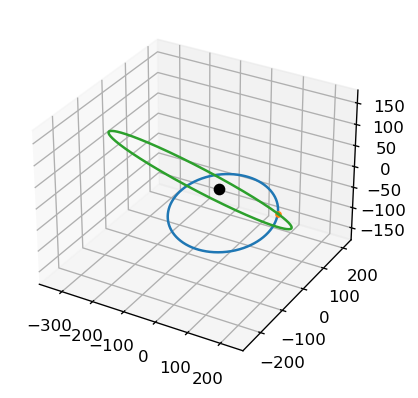

In [4]:
#Required functions:

def stumpff_S(z):
    if z > 0:
        x = np.sqrt(z)
        return (x - np.sin(x))/(x)**3
    elif z < 0:
        y = np.sqrt(-z)
        return (np.sinh(y) - y)/(y)**3
    else:
        return (1/6)
        
def stumpff_C(z):
    if z > 0:
        return (1 - np.cos(np.sqrt(z)))/z
    elif z < 0:
        return (np.cosh(np.sqrt(-z)) - 1)/(-z)
    else:
        return(1/2)

def find_f_x(x, r0, a):
    A = x**2/r0
    B = stumpff_C(x**2/a)
    return 1 - A*B

def find_g_x(x, dt, mu, a):
    A = x**3/np.sqrt(mu)
    return dt - A*stumpff_S(x**2/a)

def find_f_dot_x(x, mu, r, r0, a):
    A = np.sqrt(mu)/(r*r0)
    B = stumpff_S(x**2/a)*(x**3/a)
    return A*(B - x)

def find_g_dot_x(x, r, a):
    A = x**2/r
    return 1 - A*stumpff_C(x**2/a)

def dt_from_x(x, args):
    r0, vr0, mu, a = args
    #Equation 3.46
    A = (r0*vr0/np.sqrt(mu))*(x**2)*stumpff_C(x**2/a)
    B = (1 - r0/a)*(x**3)*stumpff_S(x**2/a)
    C = r0*x
    LHS = A + B + C
    return LHS/np.sqrt(mu)
    
def r_from_x(r0_vector, v0_vector, x, dt, a, mu):
    r0 = np.linalg.norm(r0_vector)
    f = find_f_x(x, r0, a)
    g = find_g_x(x, dt, mu, a)
    return f*r0_vector + g*v0_vector

def e_from_r0v0(r0_v, v0_v, mu):
    r0_vector = np.array(r0_v)
    v0_vector = np.array(v0_v)
    
    r0 = np.linalg.norm(r0_vector)
    v0 = np.linalg.norm(v0_vector)
    vr0 = np.dot(r0_vector, v0_vector)/r0

    #Find eccentricity
    A = (v0**2 - (mu/r0))*r0_vector
    B = -r0*vr0*v0_vector
    e_vector = (1/mu)*(A + B)
    e = np.linalg.norm(e_vector)
    return e

#Actual functions:

def orbit_r0v0(r0_v, v0_v, mu, resolution=1000, hyp_span=1):
    r0_vector = np.array(r0_v)
    v0_vector = np.array(v0_v)
    
    #Use Algorithm 3.4
    r0 = np.linalg.norm(r0_vector)
    v0 = np.linalg.norm(v0_vector)

    vr0 = np.dot(r0_vector, v0_vector)/r0
    a_orbit = 1/((2/r0) - (v0**2/mu))
    
    #Check for orbit type, define x_range
    #resolution = number of points plotted
    #span = width of parabolic orbit plotted\

    e = e_from_r0v0(r0_v, v0_v, mu)
    if e >= 1:
        x_max = np.sqrt(np.abs(a_orbit))
        x_array = np.linspace(-hyp_span*x_max, hyp_span*x_max, resolution)
        pos_array = np.array([r_from_x(r0_vector, v0_vector,
                              x, dt_from_x(x, [r0, vr0, mu, a_orbit]),
                              a_orbit, mu) for x in x_array])         
        
    else:
        x_max = np.sqrt(a_orbit)*(2*np.pi)
        x_array = np.linspace(0, x_max, resolution)
        pos_array = np.array([r_from_x(r0_vector, v0_vector,
                              x, dt_from_x(x, [r0, vr0, mu, a_orbit]),
                              a_orbit, mu) for x in x_array]) 
    
    return pos_array

def maneuver_plot(r0_v, v0_v, dv_v, mu, resolution=1000, hyp_span=1):
    #Plot initial orbit
    initial_orbit = orbit_r0v0(r0_v, v0_v, mu, resolution=resolution,
                               hyp_span=hyp_span)
      
    fig = plt.figure(dpi = 120)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(initial_orbit[:, 0], initial_orbit[:, 1],
            initial_orbit[:, 2])
    ax.plot([np.array(r0_v)[0]], [np.array(r0_v)[1]],
             [np.array(r0_v)[2]], '.')
    ax.plot([0], [0], [0], 'o', color='k') 
    
    #Find new orbit
    v0_dv = np.array(v0_v) + np.array(dv_v)
    new_orbit = orbit_r0v0(r0_v, v0_dv, mu, resolution=resolution,
                           hyp_span=hyp_span)
    
    #Plot new orbit 
    ax.plot(new_orbit[:, 0], new_orbit[:, 1],
            new_orbit[:, 2])

######

#Units of r0 in km, v0 in km/s, mu in km3/s2
#Change units as necessary (all consistent)
#mu is G*M, m mass of primary body, G is gravitational constant

maneuver_plot([203, -30, 0],
              [-18, 33, 0],
              [23, 1, -30],
              344000, hyp_span=5)

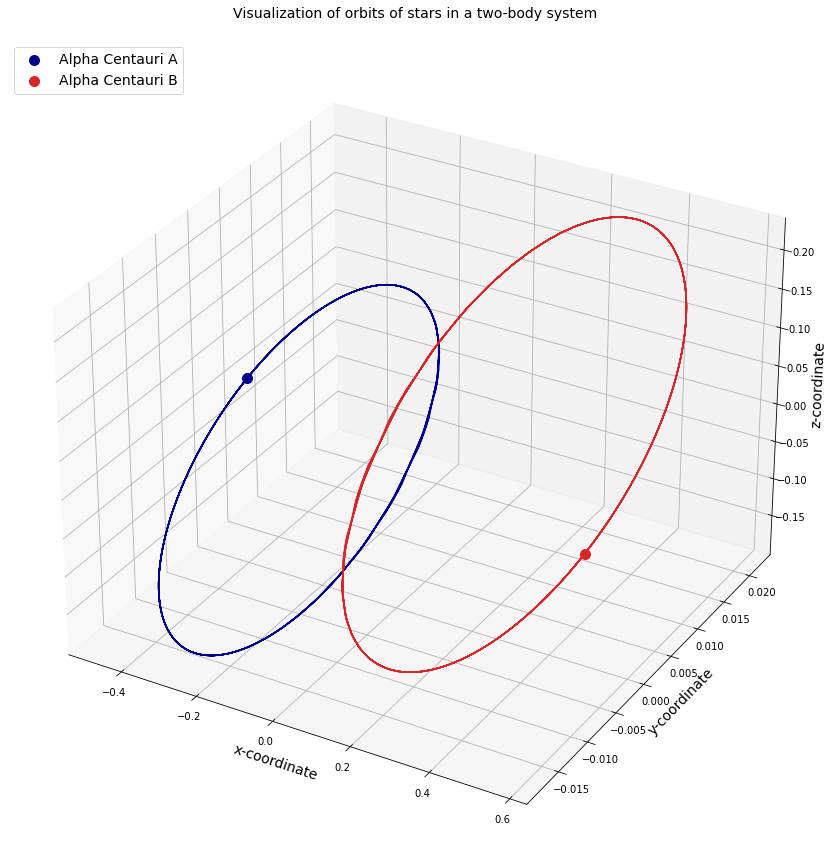

In [14]:
import scipy as sci
import matplotlib.pyplot as plt

#Define universal gravitation constant
G = 6.67408e-11

#Reference quantities
m0 = 1.989e+30 #kg #mass of the sun
r0 = 5.326e+12 #m #distance between stars in Alpha Centauri
v0 = 30000 #m/s #relative velocity of earth around the sun
t0 = 79.91*365*24*3600*0.51 #s #orbital period of Alpha Centauri

#Net constants
k1 = G*t0*m0/(r0**2*v0)
k2 = v0*t0/r0

#Define masses
m1 = 1.1 #Alpha Centauri A
m2 = 0.907 #Alpha Centauri B

#Define initial position vectors
r1 = np.array([-0.5,0,0],dtype="float64")
r2 = np.array([0.5,0,0],dtype="float64")

#Find Centre of Mass
r_com = (m1*r1+m2*r2)/(m1+m2)

#Define initial velocities
v1 = np.array([0.01,0.01,0],dtype="float64")
v2 = np.array([-0.05,0,-0.1],dtype="float64")

#Find velocity of COM
v_com = m1*v1+m2*v2/(m1+m2)

#initial state
yinit = np.array([r1, r2, v1, v2])
yinit = yinit.flatten()

#A function defining the equations of motion
def TwoBodyEquations(w,t,G,m1,m2):
    r1 = w[:3]
    r2 = w[3:6]
    v1 = w[6:9]
    v2 = w[9:12]
    r  = sci.linalg.norm(r2-r1) #Calculate magnitude or norm of vector
    dv1dt = k1*m2*(r2-r1)/r**3
    dv2dt = k1*m1*(r1-r2)/r**3
    dr1dt = k2*v1
    dr2dt = k2*v2
    r_derivs=np.concatenate((dr1dt,dr2dt))
    derivs=np.concatenate((r_derivs,dv1dt,dv2dt))
    return derivs

#Package initial parameters
init_params=np.array([r1,r2,v1,v2]) #create array of initial params
init_params=init_params.flatten() #flatten array to make it 1D
time_span=np.linspace(0,8,500) #8 orbital periods and 500 points

#Run the ODE solver
ysol=sci.integrate.odeint(TwoBodyEquations,init_params,time_span,args=(G,m1,m2))

r1_sol = ysol[:, :3]
r2_sol = ysol[:, 3:6]
'''
#Create figure
fig=plt.figure(figsize=(15,15))
#Create 3D axes
ax=plt.gca(projection="3d")
#Plot the orbits
ax.plot(r1_sol[:,0],r1_sol[:,1],r1_sol[:,2],color="darkblue")
ax.plot(r2_sol[:,0],r2_sol[:,1],r2_sol[:,2],color="tab:red")
#Plot the final positions of the stars
ax.scatter(r1_sol[-1,0],r1_sol[-1,1],r1_sol[-1,2],color="darkblue",marker="o",s=100,label="Alpha Centauri A")
ax.scatter(r2_sol[-1,0],r2_sol[-1,1],r2_sol[-1,2],color="tab:red",marker="o",s=100,label="Alpha Centauri B")
#Add a few more bells and whistles
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Visualization of orbits of stars in a two-body system\n",fontsize=14)
ax.legend(loc="upper left",fontsize=14)
plt.show()
'''
#Find location of COM
rcom_sol=(m1*r1_sol+m2*r2_sol)/(m1+m2)
#Find location of Alpha Centauri A w.r.t COM
r1com_sol=r1_sol-rcom_sol
#Find location of Alpha Centauri B w.r.t COM
r2com_sol=r2_sol-rcom_sol

#Create figure
fig=plt.figure(figsize=(15,15))

#Create 3D axes
ax=plt.axes(projection="3d")

#Plot the orbits
ax.plot(r1com_sol[:,0],r1com_sol[:,1],r1com_sol[:,2],color="darkblue")
ax.plot(r2com_sol[:,0],r2com_sol[:,1],r2com_sol[:,2],color="tab:red")

#Plot the final positions of the stars
ax.scatter(r1com_sol[-1,0],r1com_sol[-1,1],r1com_sol[-1,2],color="darkblue",marker="o",s=100,label="Alpha Centauri A")
ax.scatter(r2com_sol[-1,0],r2com_sol[-1,1],r2com_sol[-1,2],color="tab:red",marker="o",s=100,label="Alpha Centauri B")

#Add a few more bells and whistles
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Visualization of orbits of stars in a two-body system\n",fontsize=14)
ax.legend(loc="upper left",fontsize=14)

plt.show()